In [27]:
import pyro
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO, autoguide
import torch
from torch.nn.functional import softplus
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ann
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import numpy as np
import tempfile
from numpyro.distributions import TransformedDistribution, transforms
from torch.distributions.transforms import SoftmaxTransform
from scipy.stats import spearmanr
import torch

In [2]:
data = ann.read_h5ad("/mnt/storage/thien/projectdata/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [45]:
# simulate data\n,
n_obs = 100
n_features1 = 20
n_features2 = 30
n_factors = 20

torch.manual_seed(2024)
Z_in = torch.randn(n_obs, n_factors)
W1_in = torch.randn(n_features1, n_factors)
W2_in = torch.randn(n_features2, n_factors)

# create observated values from the simulated factor and weight matrix with some random noise\n,
Y1 = torch.matmul(Z_in, W1_in.t()) + 0.2 * torch.randn(n_obs, n_features1)
Y2 = torch.matmul(Z_in, W2_in.t()) + 0.2 * torch.randn(n_obs, n_features2)
#print(Y.shape)\n,
#print(Y)\n,

Y = torch.cat((Y1.T, Y2.T)).T
#train_size = int(0.2*Y.shape[0])
#train_data = Y[:train_size,:]
#test_data = Y[train_size:,:]


In [5]:
class FA(PyroModule):
    def __init__(self, Y1, Y2, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.Y1 = Y1
        self.Y2 = Y2
        self.K = K
        
        self.num_samples = self.Y1.shape[0]
        self.num_features1 = self.Y1.shape[1]
        self.num_features2 = self.Y2.shape[1]
        
        self.sample_plate = pyro.plate("sample", self.num_samples)
        self.feature_plate1 = pyro.plate("feature1", self.num_features1)
        self.feature_plate2 = pyro.plate("feature2", self.num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
        
    def model(self):
        """
        how to generate a matrix
        """
        with self.latent_factor_plate:
            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                W1 = pyro.sample("W1", pyro.distributions.Normal(0., 1.))  

            with self.feature_plate2:
                # sample weight matrix with Normal prior distribution
                W2 = pyro.sample("W2", pyro.distributions.Normal(0., 1.))               
                
            with self.sample_plate:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., 1.))
        
        # estimate for Y
        Y1_hat = torch.matmul(Z, W1.t())
        Y2_hat = torch.matmul(Z, W2.t())
        
        with pyro.plate("feature1_", self.Y1.shape[1]), pyro.plate("sample_", self.Y1.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y1, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y1))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y1 = torch.nan_to_num(self.Y1, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs1", pyro.distributions.Normal(Y1_hat, scale), obs=self.Y1)


        with pyro.plate("feature2_", self.Y2.shape[1]), pyro.plate("sample2_", self.Y2.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y2, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y2))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y2 = torch.nan_to_num(self.Y2, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale2", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs2", pyro.distributions.Normal(Y2_hat, scale), obs=self.Y2)


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.02})
        elbo = Trace_ELBO()
        guide = autoguide.AutoDelta(self.model)
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 2000
        train_loss = []
        for j in range(num_iterations):
            # calculate the loss and take a gradient step
            loss = svi.step()

            train_loss.append(loss/self.Y1.shape[0])              
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.Y1.shape[0]))
            
            
        
        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide([Y1])
        
        return train_loss, map_estimates

In [ ]:
class FA(PyroModule):
    def __init__(self, train_data, test_data, n_features1, n_features2, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.num_features1 = n_features1
        self.num_features2 = n_features2
        self.Y1 = train_data[:,:n_features1]
        self.Y2 = train_data[:,n_features1:]
        self.K = K
        self.train_data = train_data
        self.test_data = test_data
        
        self.num_samples = self.Y1.shape[0]
        
        self.sample_plate = pyro.plate("sample", self.num_samples)
        self.feature_plate1 = pyro.plate("feature1", self.num_features1)
        self.feature_plate2 = pyro.plate("feature2", self.num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
    def model(self):
        """
        how to generate a matrix
        """
        with self.latent_factor_plate:
            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                W1 = pyro.sample("W1", pyro.distributions.Normal(0., 1.))  

            with self.feature_plate2:
                # sample weight matrix with Normal prior distribution
                W2 = pyro.sample("W2", pyro.distributions.Normal(0., 1.))               
                
            with self.sample_plate:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., 1.))
        
        # estimate for Y
        Y1_hat = torch.matmul(Z, W1.t())
        Y2_hat = torch.matmul(Z, W2.t())
        
        with pyro.plate("feature1_", self.Y1.shape[1]), pyro.plate("sample_", self.Y1.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y1, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y1))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y1 = torch.nan_to_num(self.Y1, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs1", pyro.distributions.Normal(Y1_hat, scale), obs=self.Y1)


        with pyro.plate("feature2_", self.Y2.shape[1]), pyro.plate("sample2_", self.Y2.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y2, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y2))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y2 = torch.nan_to_num(self.Y2, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale2", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs2", pyro.distributions.Normal(Y2_hat, scale), obs=self.Y2)


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.02})
        elbo = Trace_ELBO()
        guide = autoguide.AutoNormal(self.model)
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 2000
        train_loss = []
        test_loss = []
        for j in range(num_iterations):
        #for j in enumerate(self.train_dataloader):
            # calculate the loss and take a gradient step
            loss = svi.step()

            train_loss.append(loss/self.Y1.shape[0])
            #    test_loss.append(elbo.loss(self.model, guide, test_data))
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.Y1.shape[0]))
            
            #with torch.no_grad():  # for logging only
                #train_loss = elbo.loss(self.model, guide, self.train_data) # or average over batch_loss
                #test_loss = elbo.loss(self.model, guide, self.test_data)
            #print(train_loss, test_loss)
        torch.save({"model": self.state_dict(), "guide" : guide}, "/mnt/storage/thien/FA_model.pt")
        pyro.get_param_store().save("/mnt/storage/thien/FA_model_params.pt")

        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide(Y)
        
        return train_loss, map_estimates

In [7]:
class FA(PyroModule):
    def __init__(self, train_data, test_data, n_features1, n_features2, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.num_features1 = n_features1
        self.num_features2 = n_features2
        self.Y1 = train_data[:,:n_features1]
        self.Y2 = train_data[:,n_features1:]
        self.K = K
        self.train_data = train_data
        self.test_data = test_data
        
        self.num_samples = self.Y1.shape[0]
        
        self.sample_plate = pyro.plate("sample", self.num_samples)
        self.feature_plate1 = pyro.plate("feature1", self.num_features1)
        self.feature_plate2 = pyro.plate("feature2", self.num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
    def model(self):
        """
        how to generate a matrix
        """
        with self.latent_factor_plate:
            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                #W1 = pyro.sample("W1", pyro.distributions.Normal(0., 1.))  
                theta1 = pyro.sample("theta1", pyro.distributions.Beta(1., 1.))
                alpha1 = pyro.sample("alpha1", pyro.distributions.Gamma(torch.tensor([10 ** -1]), torch.tensor([10 ** -1])))
                W1_hat = pyro.sample("w1_hat", pyro.distributions.Normal(0., 1./alpha1))*pyro.sample("s1", pyro.distributions.Bernoulli(theta1))

            with self.feature_plate2:
                # sample weight matrix with Normal prior distribution
                #W2 = pyro.sample("W2", pyro.distributions.Normal(0., 1.))  
                theta2 = pyro.sample("theta2", pyro.distributions.Beta(1., 1.))
                alpha2 = pyro.sample("alpha2", pyro.distributions.Gamma(torch.tensor([10 ** -1]), torch.tensor([10 ** -1])))
                W2_hat = pyro.sample("w2_hat",pyro.distributions.Normal(0., 1./alpha2))*pyro.sample("s2",pyro.distributions.Bernoulli(theta2))          
                
            with self.sample_plate:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., 1.))
        
        # estimate for Y
        Y1_hat = torch.matmul(Z, W1_hat.t())
        Y2_hat = torch.matmul(Z, W2_hat.t())
        
        with pyro.plate("feature1_", self.Y1.shape[1]), pyro.plate("sample_", self.Y1.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y1, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y1))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y1 = torch.nan_to_num(self.Y1, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    precision1 = pyro.sample("precision1", pyro.distributions.Gamma(torch.tensor([10 ** -14]), torch.tensor([10 ** -14])))
                    print(precision1)
                    scale = pyro.sample("scale", pyro.distributions.LogNormal(0., 1./precision1))
                    print(scale)
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs1", pyro.distributions.Normal(Y1_hat, scale), obs=self.Y1)


        with pyro.plate("feature2_", self.Y2.shape[1]), pyro.plate("sample2_", self.Y2.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y2, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y2))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y2 = torch.nan_to_num(self.Y2, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    precision2 = pyro.sample("precision2", pyro.distributions.Gamma(torch.tensor([10 ** -14]), torch.tensor([10 ** -14])))
                    scale = pyro.sample("scale2", pyro.distributions.LogNormal(0., 1./precision2))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs2", pyro.distributions.Normal(Y2_hat, scale), obs=self.Y2)


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.02})
        elbo = Trace_ELBO()
        guide = autoguide.AutoGuideList(self.model)
        guide.append(autoguide.AutoNormal(pyro.poutine.block(self.model, hide=['s1', "s2"])))
        guide.append(autoguide.AutoDiscreteParallel(pyro.poutine.block(self.model, expose=["s1", "s2"])))
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 2000
        train_loss = []
        test_loss = []
        for j in range(num_iterations):
        #for j in enumerate(self.train_dataloader):
            # calculate the loss and take a gradient step
            loss = svi.step()

            train_loss.append(loss/self.Y1.shape[0])
            #    test_loss.append(elbo.loss(self.model, guide, test_data))
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.Y1.shape[0]))
            
            #with torch.no_grad():  # for logging only
                #train_loss = elbo.loss(self.model, guide, self.train_data) # or average over batch_loss
                #test_loss = elbo.loss(self.model, guide, self.test_data)
            #print(train_loss, test_loss)
        #torch.save({"model": self.state_dict(), "guide" : guide}, "/mnt/storage/thien/FA_model.pt")
        #pyro.get_param_store().save("/mnt/storage/thien/FA_model_params.pt")

        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide(Y)
        
        return train_loss, map_estimates

In [40]:
class FA(PyroModule):
    def __init__(self, train_data, test_data, n_features1, n_features2, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.num_features1 = n_features1
        self.num_features2 = n_features2
        self.Y1 = train_data[:,:n_features1]
        self.Y2 = train_data[:,n_features1:]
        self.K = K
        self.train_data = train_data
        self.test_data = test_data
        
        self.num_samples = self.Y1.shape[0]
        
        self.sample_plate = pyro.plate("sample", self.num_samples)
        self.feature_plate1 = pyro.plate("feature1", self.num_features1)
        self.feature_plate2 = pyro.plate("feature2", self.num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
    def model(self):
        """
        how to generate a matrix
        """
        with self.latent_factor_plate:
            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                #W1 = pyro.sample("W1", pyro.distributions.Normal(0., 1.))  
                theta1 = pyro.sample("theta1", pyro.distributions.Beta(1., 1.))
                alpha1 = pyro.sample("alpha1", pyro.distributions.Gamma(torch.tensor(10**-14), torch.tensor(10**-14)))
                W1_hat = pyro.sample("w1_hat", pyro.distributions.Normal(0., 1./alpha1))*pyro.sample("s1", pyro.distributions.Bernoulli(theta1))

            with self.feature_plate2:
                # sample weight matrix with Normal prior distribution
                #W2 = pyro.sample("W2", pyro.distributions.Normal(0., 1.))  
                theta2 = pyro.sample("theta2", pyro.distributions.Beta(1., 1.))
                alpha2 = pyro.sample("alpha2", pyro.distributions.Gamma(torch.tensor(10**-14), torch.tensor(10**-14)))
                W2_hat = pyro.sample("w2_hat",pyro.distributions.Normal(0., 1./alpha2))*pyro.sample("s2",pyro.distributions.Bernoulli(theta2))          
                
            with self.sample_plate:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., 1.))
        
        # estimate for Y
        Y1_hat = torch.matmul(Z, W1_hat.t())
        Y2_hat = torch.matmul(Z, W2_hat.t())
        
        with pyro.plate("feature1_", self.Y1.shape[1]), pyro.plate("sample_", self.Y1.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y1, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y1))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y1 = torch.nan_to_num(self.Y1, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    precision1 = pyro.sample("precision1", pyro.distributions.Gamma(torch.tensor(10.), torch.tensor(10.)))
                    #print(precision1)
                    scale = pyro.sample("scale1", pyro.distributions.LogNormal(0., 1./(precision1+1e-4)))
                    #print(scale)
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs1", pyro.distributions.Normal(Y1_hat, scale), obs=self.Y1)


        with pyro.plate("feature2_", self.Y2.shape[1]), pyro.plate("sample2_", self.Y2.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y2, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y2))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y2 = torch.nan_to_num(self.Y2, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    precision2 = pyro.sample("precision2", pyro.distributions.Gamma(torch.tensor(10.), torch.tensor(10.)))
                    scale = pyro.sample("scale2", pyro.distributions.LogNormal(0., 1./(precision2)))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs2", pyro.distributions.Normal(Y2_hat, scale), obs=self.Y2)


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.02})
        elbo = Trace_ELBO()
        #guide = autoguide.AutoNormal(pyro.poutine.block(self.model, hide=['s1', "s2"]))
        guide = autoguide.AutoGuideList(self.model)
        guide.append(autoguide.AutoNormal(pyro.poutine.block(self.model, hide=['s1', "s2"])))
        guide.append(autoguide.AutoDiscreteParallel(pyro.poutine.block(self.model, expose=["s1", "s2"])))
        
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 2000
        train_loss = []
        test_loss = []
        for j in range(num_iterations):
        #for j in enumerate(self.train_dataloader):
            # calculate the loss and take a gradient step
            loss = svi.step()

            train_loss.append(loss/self.Y1.shape[0])
            #    test_loss.append(elbo.loss(self.model, guide, test_data))
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.Y1.shape[0]))
            
            #with torch.no_grad():  # for logging only
                #train_loss = elbo.loss(self.model, guide, self.train_data) # or average over batch_loss
                #test_loss = elbo.loss(self.model, guide, self.test_data)
            #print(train_loss, test_loss)
        #torch.save({"model": self.state_dict(), "guide" : guide}, "/mnt/storage/thien/FA_model.pt")
        #pyro.get_param_store().save("/mnt/storage/thien/FA_model_params.pt")

        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide(Y)
        
        return train_loss, map_estimates

In [41]:
FA_model = FA(train_data, test_data,20, 30, 5)
losses, estimates = FA_model.train()

/home/thien/.local/lib/python3.8/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'sample', 'latent factors', 'feature2', 'feature1'}
  warnings.warn(
/home/thien/.local/lib/python3.8/site-packages/pyro/util.py:544: UserWarning: s1Found sample sites configured for enumeration:, s2
If you want to enumerate sites, you need to use TraceEnum_ELBO instead.
  warnings.warn(


[iteration 0001] loss: 788.0256
[iteration 0201] loss: 534.4319
[iteration 0401] loss: 531.1784
[iteration 0601] loss: 532.2947
[iteration 0801] loss: 528.3540
[iteration 1001] loss: 525.7139
[iteration 1201] loss: 529.9909
[iteration 1401] loss: 524.0606
[iteration 1601] loss: 533.1620
[iteration 1801] loss: 536.9749


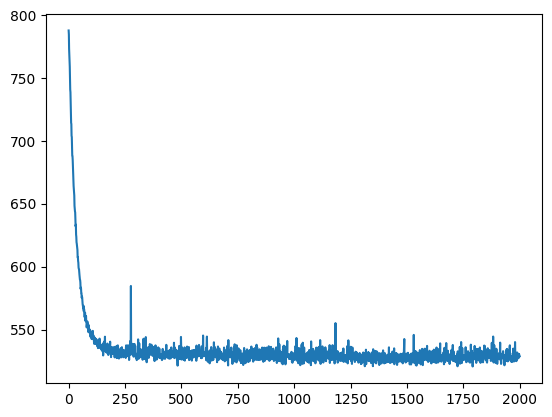

In [43]:
plt.plot(losses)

In [16]:
class FA(PyroModule):
    def __init__(self, dat, n_features1, n_features2, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.num_features1 = n_features1
        self.num_features2 = n_features2
        self.Y1 = dat[:,:n_features1]
        self.Y2 = dat[:,n_features1:]
        self.K = K
        
        self.num_samples = self.Y1.shape[0]
        
        self.sample_plate = pyro.plate("sample", self.num_samples)
        self.feature_plate1 = pyro.plate("feature1", self.num_features1)
        self.feature_plate2 = pyro.plate("feature2", self.num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
    def model(self):
        """
        how to generate a matrix
        """
        with self.latent_factor_plate:
            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                #W1 = pyro.sample("W1", pyro.distributions.Normal(0., 1.))  
                theta1 = pyro.sample("theta1", pyro.distributions.Beta(1., 1.))
                alpha1 = pyro.sample("alpha1", pyro.distributions.Gamma(torch.tensor(10**-14), torch.tensor(10**-14)))
                W1_hat = pyro.sample("w1_hat", pyro.distributions.Normal(0., 1./alpha1))*pyro.sample("s1", pyro.distributions.Bernoulli(theta1))

            with self.feature_plate2:
                # sample weight matrix with Normal prior distribution
                #W2 = pyro.sample("W2", pyro.distributions.Normal(0., 1.))  
                theta2 = pyro.sample("theta2", pyro.distributions.Beta(1., 1.))
                alpha2 = pyro.sample("alpha2", pyro.distributions.Gamma(torch.tensor(10**-14), torch.tensor(10**-14)))
                W2_hat = pyro.sample("w2_hat",pyro.distributions.Normal(0., 1./alpha2))*pyro.sample("s2",pyro.distributions.Bernoulli(theta2))          
                
            with self.sample_plate:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., 1.))
        
        # estimate for Y
        Y1_hat = torch.matmul(Z, W1_hat.t())
        Y2_hat = torch.matmul(Z, W2_hat.t())
        
        with pyro.plate("feature1_", self.Y1.shape[1]), pyro.plate("sample_", self.Y1.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y1, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y1))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y1 = torch.nan_to_num(self.Y1, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    precision1 = pyro.sample("precision1", pyro.distributions.Gamma(torch.tensor(10.), torch.tensor(10.)))
                    #print(precision1)
                    scale = pyro.sample("scale1", pyro.distributions.LogNormal(0., 1./(precision1)))
                    #print(scale)
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs1", pyro.distributions.Normal(Y1_hat, scale), obs=self.Y1)
                    #Y1_sampled = pyro.distributions.Normal(Y1_hat, scale)
                    #pyro.sample("obs1", pyro.distributions.TransformedDistribution(Y1_sampled, SoftmaxTransform()), obs=self.Y1)


        with pyro.plate("feature2_", self.Y2.shape[1]), pyro.plate("sample2_", self.Y2.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y2, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y2))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y2 = torch.nan_to_num(self.Y2, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    precision2 = pyro.sample("precision2", pyro.distributions.Gamma(torch.tensor(10.), torch.tensor(10.)))
                    scale = pyro.sample("scale2", pyro.distributions.LogNormal(0., 1./(precision2)))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs2", pyro.distributions.Normal(Y2_hat, scale), obs=self.Y2)
                    #Y2_sampled = pyro.distributions.Normal(Y2_hat, scale)
                    #pyro.sample("obs2", pyro.distributions.TransformedDistribution(Y2_sampled, SoftmaxTransform()), obs=self.Y2)


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.02})
        elbo = Trace_ELBO()
        #guide = autoguide.AutoNormal(pyro.poutine.block(self.model, hide=['s1', "s2"]))
        guide = autoguide.AutoGuideList(self.model)
        guide.append(autoguide.AutoNormal(pyro.poutine.block(self.model, hide=['s1', "s2"])))
        guide.append(autoguide.AutoDiscreteParallel(pyro.poutine.block(self.model, expose=["s1", "s2"])))
        
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 2000
        train_loss = []
        for j in range(num_iterations):
        #for j in enumerate(self.train_dataloader):
            # calculate the loss and take a gradient step
            loss = svi.step()

            train_loss.append(loss/self.Y1.shape[0])
            #    test_loss.append(elbo.loss(self.model, guide, test_data))
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.Y1.shape[0]))
            
            #with torch.no_grad():  # for logging only
                #train_loss = elbo.loss(self.model, guide, self.train_data) # or average over batch_loss
                #test_loss = elbo.loss(self.model, guide, self.test_data)
            #print(train_loss, test_loss)
        #torch.save({"model": self.state_dict(), "guide" : guide}, "/mnt/storage/thien/FA_model.pt")
        #pyro.get_param_store().save("/mnt/storage/thien/FA_model_params.pt")

        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide(Y)
        
        return train_loss, map_estimates

In [46]:
FA_model = FA(Y,20, 30, n_factors)
losses, estimates = FA_model.train()

/home/thien/.local/lib/python3.8/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'sample', 'feature2', 'latent factors', 'feature1'}
  warnings.warn(
/home/thien/.local/lib/python3.8/site-packages/pyro/util.py:544: UserWarning: s1Found sample sites configured for enumeration:, s2
If you want to enumerate sites, you need to use TraceEnum_ELBO instead.
  warnings.warn(


[iteration 0001] loss: 1062.8323
[iteration 0201] loss: 519.4781
[iteration 0401] loss: 517.1554
[iteration 0601] loss: 507.2190
[iteration 0801] loss: 513.6866
[iteration 1001] loss: 510.6854
[iteration 1201] loss: 506.1299
[iteration 1401] loss: 505.1242
[iteration 1601] loss: 509.6676
[iteration 1801] loss: 504.1566


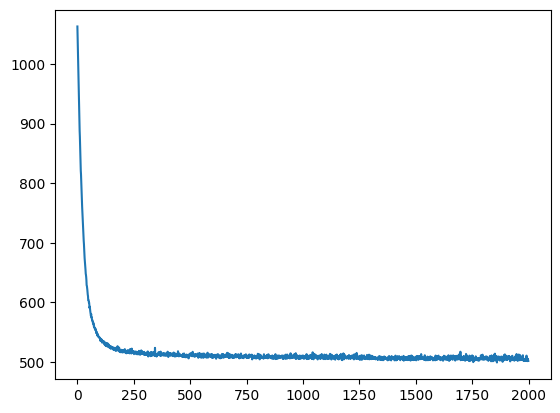

In [7]:
plt.plot(losses)

In [35]:
a = pyro.sample("test1", pyro.distributions.Gamma(torch.tensor([10.]), torch.tensor([10.])))
a
pyro.sample("test", pyro.distributions.LogNormal(0., 1./a))

tensor([1.3579])

In [47]:
correlations = []
for latent_factor in range(n_factors):
    correlations.append(spearmanr(W1_in[:,latent_factor], estimates["w1_hat"].detach().numpy()[:,latent_factor], axis=0))

In [48]:
print(correlations)

[SignificanceResult(statistic=0.45563909774436084, pvalue=0.043493409805465975), SignificanceResult(statistic=0.5849624060150376, pvalue=0.006744771529507769), SignificanceResult(statistic=-0.20601503759398496, pvalue=0.3835325530925867), SignificanceResult(statistic=-0.30075187969924805, pvalue=0.19757966317255538), SignificanceResult(statistic=-0.04210526315789473, pvalue=0.8600949015145793), SignificanceResult(statistic=0.2300751879699248, pvalue=0.3291382464700846), SignificanceResult(statistic=0.037593984962406006, pvalue=0.8749652018566716), SignificanceResult(statistic=-0.013533834586466165, pvalue=0.9548397533571387), SignificanceResult(statistic=0.28421052631578947, pvalue=0.22458459821120463), SignificanceResult(statistic=-0.38195488721804516, pvalue=0.09653857766782038), SignificanceResult(statistic=-0.024060150375939848, pvalue=0.9197997451459456), SignificanceResult(statistic=0.29473684210526313, pvalue=0.20713542085215372), SignificanceResult(statistic=-0.1834586466165413

In [13]:
pyro.clear_param_store()
saved_model_dict = torch.load("/mnt/storage/thien/FA_model.pt")
FA_model.load_state_dict(saved_model_dict['model'])
guide = saved_model_dict['guide']
pyro.get_param_store().load("/mnt/storage/thien/FA_model_params.pt")